In [1]:
# base code from 
# 1: https://docs.opencv.org/4.x/da/d0c/tutorial_bounding_rects_circles.html
# 2: https://pyimagesearch.com/2018/07/23/simple-object-tracking-with-opencv/
# 3: https://www.geeksforgeeks.org/python/python-play-a-video-using-opencv/

In [2]:
# import the necessary packages
from scipy.spatial import distance as dist  # provides functions for computing distances
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import pickle
from collections import OrderedDict 
import numpy as np  # y'all already know
from __future__ import print_function
import cv2 as cv
import argparse
import random as rng
import matplotlib.pyplot as plt

In [3]:
def thresh_callback(val, frame):
    threshold = val
    maxR = 10**(-4)
    canny_output = cv.Canny(frame, threshold, threshold * 2)

    contours, _ = cv.findContours(canny_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    # print(len(contours))

    contours_poly = [None]*len(contours)
    boundRect = []
    skipped = []
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv.approxPolyDP(c, 3, True)
        centers[i], radius[i] = cv.minEnclosingCircle(contours_poly[i])
        # print(radius[i])
        # if radius[i] <= maxR:
        boundRect.append(cv.boundingRect(contours_poly[i]))
        # else:
        #     skipped.append(c)
        # print(len(boundRect[i]))      

    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)

    for i in range(len(boundRect)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv.drawContours(drawing, contours_poly, i, color)
        cv.rectangle(drawing, (int(boundRect[i][0]), int(boundRect[i][1])), \
              (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
        # cv.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)

    # cv.imshow('Contours', drawing)
    # print(boundRect)
    return boundRect,contours_poly

In [4]:
class CentroidTracker():
	def __init__(self, maxDisappeared=100):
		self.objects = OrderedDict()
		self.nextObjectID = 0
		self.disappeared = OrderedDict()
		self.Positions = OrderedDict()
		self.maxDisappeared = maxDisappeared
	
	def update_Positions(self,frameNumber,CX,CY):
		objectIDs = list(CX.keys())
    	# objectCentroids = list(self.objects.values())
		for ID in objectIDs:
			if ID in self.Positions:
				self.Positions[ID] = np.append(self.Positions[ID],np.array([[frameNumber,CX[ID],CY[ID]]]),axis=0)
			else:
				self.Positions[ID] = np.array([[frameNumber,CX[ID],CY[ID]]])
	
	def register(self, centroid):
		# when registering an object we use the next available object
		# ID to store the centroid
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1
	
	def deregister(self, objectID):
		# to deregister an object ID we delete the object ID from
		# both of our respective dictionaries
		del self.objects[objectID]
		del self.disappeared[objectID]
	
	def update(self, rects, contoursToUse):
		# check to see if the list of input bounding box rectangles
		# is empty
		if len(rects) == 0:
			# loop over any existing tracked objects and mark them
			# as disappeared
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1
				# if we have reached a maximum number of consecutive
				# frames where a given object has been marked as
				# missing, deregister it
				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)
			# return early as there are no centroids or tracking info
			# to update
			return self.objects

        # initialize an array of input centroids for the current frame
		inputCentroids = np.zeros((len(rects), 2), dtype='int')
        # loop over the bounding box rectangles
		CX = OrderedDict()
		CY = OrderedDict()
# 		mu = [None]*len(contoursToUse)
# 		for i in range(len(contoursToUse)):
# 			mu[i] = cv.moments(contoursToUse[i])
#             # Get the mass centers
# 		for i in range(len(contoursToUse)):
#             # add 1e-5 to avoid division by zero
# 			cX = mu[i]['m10'] / (mu[i]['m00'] + 1e-5)
# 			cY = mu[i]['m01'] / (mu[i]['m00'] + 1e-5)
# 			inputCentroids[i] = (cX, cY)
        ## THIS USES BOUNDINGRECT TO CALC INPUTCENTROIDS
		for (i, (startX, startY, endX, endY)) in enumerate(rects):
            # use the bounding box coordinates to derive the centroid
			cX = int(startX + (endX / 2.0))
			cY = int(startY + (endY / 2.0))
			inputCentroids[i] = (cX, cY)
        
        # if we are currently not tracking any objects take the input
		# centroids and register each of them
		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])
        # otherwise, are are currently tracking objects so we need to
		# try to match the input centroids to existing object
		# centroids
		else:
			# grab the set of object IDs and corresponding centroids
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())
			# compute the distance between each pair of object
			# centroids and input centroids, respectively -- our
			# goal will be to match an input centroid to an existing
			# object centroid
			D = dist.cdist(np.array(objectCentroids), inputCentroids)
			# in order to perform this matching we must (1) find the
			# smallest value in each row and then (2) sort the row
			# indexes based on their minimum values so that the row
			# with the smallest value is at the *front* of the index
			# list
			rows = D.min(axis=1).argsort()
			# next, we perform a similar process on the columns by
			# finding the smallest value in each column and then
			# sorting using the previously computed row index list
			cols = D.argmin(axis=1)[rows]

            # in order to determine if we need to update, register,
			# or deregister an object we need to keep track of which
			# of the rows and column indexes we have already examined
			usedRows = set()
			usedCols = set()
			# loop over the combination of the (row, column) index
			# tuples
			for (row, col) in zip(rows, cols):
				# if we have already examined either the row or
				# column value before, ignore it
				# val
				if row in usedRows or col in usedCols:
					continue
				# otherwise, grab the object ID for the current row,
				# set its new centroid, and reset the disappeared
				# counter
				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				CX[objectID] = inputCentroids[col][0]
				CY[objectID] = inputCentroids[col][1]
				self.disappeared[objectID] = 0
				# indicate that we have examined each of the row and
				# column indexes, respectively
				usedRows.add(row)
				usedCols.add(col)
			# compute both the row and column index we have NOT yet
			# examined
			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)   
            # in the event that the number of object centroids is
			# equal or greater than the number of input centroids
			# we need to check and see if some of these objects have
			# potentially disappeared
			if D.shape[0] >= D.shape[1]:
				# loop over the unused row indexes
				for row in unusedRows:
					# grab the object ID for the corresponding row
					# index and increment the disappeared counter
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1
					# check to see if the number of consecutive
					# frames the object has been marked "disappeared"
					# for warrants deregistering the object
					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)
            # otherwise, if the number of input centroids is greater
			# than the number of existing object centroids we need to
			# register each new input centroid as a trackable object
			else:
				for col in unusedCols:
					self.register(inputCentroids[col])
		# return the set of trackable objects
		return self.objects, CX, CY

In [5]:
def rect_area(rect):
    return rect[2] * rect[3]

def overlap_area(rect1, rect2):
    x1, y1, w1, h1 = rect1
    x2, y2, w2, h2 = rect2

    # Determine the coordinates of the intersection rectangle
    x_overlap = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    y_overlap = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    return x_overlap * y_overlap

def filter_rectangles(rectangles,polyContours):
    n = len(rectangles)
    keepRects = []
    keepPolyContours = []

    for i in range(n):
        r1 = rectangles[i]
        area1 = rect_area(r1)
        ignore = False

        for j in range(n):
            if i == j:
                continue
            r2 = rectangles[j]
            overlap = overlap_area(r1, r2)

            if overlap > 0.5 * area1:
                ignore = True
                break

        if not ignore:
            keepRects.append(r1)
            keepPolyContours.append(polyContours[i])

    return keepRects,keepPolyContours

In [6]:
def init_video(filename, thresh):
    
    #set up constants and empty lists
    numGuys = []
    perimeters = []
    t=0
    a=3;
    sh = 0
    #initialize centroid tracker
    cTracker = CentroidTracker()

    # Create a VideoCapture object and read from input file

    cap = cv.VideoCapture(filename)
    
    # Check if camera opened successfully
    if (cap.isOpened()== False):
        print("Error opening video file")

    kernel1 = cv.getStructuringElement(cv.MORPH_RECT,(a,a))
    kernel2 = cv.getStructuringElement(cv.MORPH_CROSS,(a,a))
    kernel3 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(a,a))
    
    while(cap.isOpened()):
        t+=1
        #print(t)
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            # this block zeros all non-pink pixels
            hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
            sensitivity = 150
            lower_white = np.array([150, 85, 255-sensitivity])
            upper_white = np.array([200, 255, 255])
            mask = cv.inRange(hsv, lower_white, upper_white)
            inv_mask = cv.bitwise_not(mask)
            frame = cv.bitwise_and(frame, frame, mask = mask)
            
            # turns all non-black pixels white
            black_color = np.array([0, 0, 0])
            non_black_mask = np.any(frame != black_color, axis=-1)
            frame[non_black_mask] = [255, 255, 255]
            
            #dilates the white pixels (kernel,a, & number of iterations should be played with)
            #frame = cv.erode(frame, kernel3,iterations = 1)
            frame = cv.dilate(frame, kernel3,iterations = 1)
            if sh==0:
                sh = np.shape(frame)

            
            #gets ALL rectangles
            rects,contoursPoly = thresh_callback(thresh, frame)
            rectsToUse = []
            polyContoursToUse = []
            color = (255,0,0)
            Rcolor = (0,0,255)

            for i in range(len(rects)):
                contour = rects[i]
                p = 2*contour[2]+2*contour[3]
                perimeters.append(p)
                
                #thresholds the perimeters to not include tiny boxes
                if p > 50:
                    
                    rectsToUse.append(contour)
                    polyContoursToUse.append(contoursPoly[i])
            rectsToUse,polyContoursToUse = filter_rectangles(rectsToUse,polyContoursToUse)
#             for contour in rectsToUse:
#                 cv.rectangle(frame, (int(contour[0]), int(contour[1])),
#                                      (int(contour[0]+contour[2]), int(contour[1]+contour[3])), color, 2)
            #print(len(rectsToUse))
            #print(np.sum(boolsInside))
            
            #sets up the waitkey
            # Press Q on keyboard to exit

            if cv.waitKey(25) & 0xFF == ord('q'):
                break
                
            #if there are no rectangles above threshold perimeter move on
            if not rectsToUse:
                continue
            
            #
            
            #update the tracker
            #---------------------------------------
            
            
            
            #---------------------------------------
            objects,CX,CY = cTracker.update(rectsToUse,polyContoursToUse)
            numGuys.append(len(rectsToUse))
            
            #keep track of positions
            cTracker.update_Positions(t,CX,CY)
#             keys = CX.keys()
#             for key in keys:
#                 cv.circle(frame,(CX[key],CY[key]),radius=1,color=[0,0,255],thickness=3)
            
            #cv.imshow('frame', frame)

    # Break the loop
        else:
            break
    
    # When everything done, release
    # the video capture object
    cap.release()
    cv.destroyAllWindows()
    
    #histograms the perimeters
#     plt.hist(perimeters,bins=50)
#     plt.show() 
    
    #histograms the number of rectangles we're counting
#     plt.hist(numGuys,bins=20)
#     plt.xlabel("Number of Agents")
#     plt.ylabel("Count")
#     plt.title("Accuracy of Agent Finding")
#     plt.show()
    
    #cTracker.Positions contains a dictionary n->arr
    #n is an integer keeping track of which object we're looking at
    #arr is a 2D array K rows, 3 columns; each row is OTF [time, x ,y]
    #K is the amount of tiqme for which the object is tracked
    
    
    return numGuys,cTracker.Positions,t,sh

In [7]:
def getHeights(filename,videoNumber):
    #vids are ordered chronologically
    colToUse = {1:(1,2),2:(4,5),3:(7,8),4:(10,11)}
    
    data = np.genfromtxt(filename, delimiter = ",",skip_header = 1,usecols = colToUse[videoNumber])
    altitude = data[:,0]
    altitude = altitude-altitude[0]
    isVideo = data[:,1]
    altitude = altitude[~np.isnan(altitude)]
    altitude = altitude*0.3048
    isVideo = isVideo[0:np.size(altitude)]
    if not (videoNumber==1):
        minIndex = np.min(np.where(isVideo==1))
        altitude = altitude[minIndex:]
        isVideo = isVideo[minIndex:]
    return altitude,isVideo

def pixelMeterRatio(height,frameShape):
    #outputs a number in meters/pixels
    
    #focal length 35mm
    #
    sensorWidth = np.sqrt(7.65**2-4.55**2)/1000
    sensorHeight = 4.55/1000
    #Horiz GSD
    #(height * Sensor Width) / (Focal Length * frameWidth)
    #Vertical GSD:
    #(height * Sensor Height) / (Focal Length * FrameHeight)
    
    horizGSD = (height*sensorWidth)/(0.035*frameShape[1])
    VerticalGSD = (height*sensorHeight)/(0.035*frameShape[0])
    
#     initialAltitude = 6.889764004*0.3048
#   initialAltitude/(height*474)
    return (horizGSD,VerticalGSD)


In [8]:
def get_Displacements(dictionary,heights,frameShape):
    if (not dictionary):
        print("The dictionary or heights is empty.")
    Displacements = OrderedDict()
    pos_keys = dictionary.keys()
    
    
    for k in pos_keys:
        T = len(dictionary[k][:,0])
        Displacements[k] = np.zeros((T,4))
        hIndex = 0
        for t in range(T):
            
            if t == 0:
                continue
            else:
                if t%3==0:
                    hIndex+=1
                h = heights[hIndex]
                conversion = pixelMeterRatio(h,frameShape)
                
                x0,y0 = dictionary[k][t-1, 1],dictionary[k][t-1, 2]
                x1,y1 = dictionary[k][t, 1],dictionary[k][t, 2]
                
                
                
#                 r = np.sqrt((x0-medianX)**2 + (y0-medianY)**2)
                
                dt = dictionary[k][t, 0] - dictionary[k][t-1, 0]
                u_x = conversion[0]*(x1 - x0)/dt
                u_y = conversion[1]*(y1 - y0)/dt
                
                
                u_mag = np.sqrt(u_x**2 + u_y**2)
#                 apparentSize = u_mag
#                 if (apparentSize == 0):
#                     new_items = np.array([dictionary[k][t, 0], u_x, u_y, u_mag])
#                     continue
#                 actualSize = np.sqrt(r**2+h**2)*apparentSize/(h*np.cos(np.atan(r/h)))
#                 u_x = u_x*actualSize/apparentSize
#                 u_y = u_y*actualSize/apparentSize
#                 u_mag = actualSize
                
                
                new_items = np.array([dictionary[k][t, 0], u_x, u_y, u_mag])
                Displacements[k][t] = new_items
    
    return Displacements



In [9]:
def GetvMaxSheep(U):
    key = U.keys()
    vmax = [0,0]
    allVNorms = np.array([])
    for k in key:
        if (np.size(U[k][:,3]))<100:
            continue
        allVNorms = np.append(allVNorms,U[k][:,3])
        vmaxTemp = np.max(U[k][:,3])
        if vmaxTemp>vmax[0]:
            vmax[0] = vmaxTemp
            vmax[1] = k
#     plt.hist(allVNorms)
#     plt.xlabel("Pixels/Frame")
#     plt.ylabel("Count")
#     plt.title("Video #" + str(histNumber))
#     plt.show() 
    return allVNorms

In [10]:
def getGenAtT(posDict,tmax):
    pos_keys = posDict.keys()
    generatorsAtT = OrderedDict()
    for t in range(1,tmax):
        generatorsAtT[t] = []
        for k in pos_keys:
            if np.isin(t,pos[k][:,0]):
                generatorsAtT[t].append(k)
    return generatorsAtT



In [11]:
def getDistBetweenNeighbours(posDicts,heights,frameShape,generatorsAtT):
    L = []
    hIndex = 0
    for t in range(1,tmax):
        N = len(generatorsAtT[t])
        if t%3==0:
            hIndex+=1
        h = heights[hIndex]
        conversion = pixelMeterRatio(h,frameShape)
        if N==0:
            continue
        positionsAtT = []
        for gen in generatorsAtT[t]:
            row = np.where(pos[gen][:,0]==t)[0][0]
            positionsAtT.append(pos[gen][row,1:])
        positionsAtT = np.array(positionsAtT)
        for i in range(0,N):
            minDist = np.inf
            indexMin = 0
            for j in range(0,N):
                if i==j:
                    continue
                tempDist = np.linalg.norm(positionsAtT[i,:]-positionsAtT[j,:])
                if tempDist<minDist:
                    minDist = tempDist
                    indexMin = j
            LVector = np.linalg.norm(positionsAtT[i,:]-positionsAtT[indexMin,:])
            LVector = LVector*np.array([conversion[0],conversion[1]])
            L.append(np.linalg.norm(LVector))
    return L

In [12]:


def get_Pressure(dictionary,generatorsAtT,heights,frameShape):
    generators = np.array([[]])
    pressures = np.zeros((tmax,2))
    hIndex = 0
    for t in range(1,tmax):
        
        if t%3==0:
            hIndex+=1
        h = heights[hIndex]
        conversion = pixelMeterRatio(h,frameShape)
        
        N = len(generatorsAtT[t])
        areas = np.array([])

        pressures[t-1][0] = t

        if N==0:
            continue
        gen = np.zeros((len(generatorsAtT[t]),2))
        counter = 0
        for k in generatorsAtT[t]:
            row = np.where(pos[k][:,0]==t)[0][0]
            gen[counter] = (pos[k][row][1:])
            counter+=1
        vor = Voronoi(np.array(gen))
        finite_regions = [region for region in vor.regions if not -1 in region and len(region) > 0]
        region_polygons = []
        for region_indices in finite_regions:
            polygon_vertices = vor.vertices[region_indices]
            region_polygons.append(polygon_vertices)
    
        for poly_vertices in region_polygons:
            polygon = Polygon(poly_vertices)
            areas = (np.append(areas, polygon.area))
        p_t = (1/N)*np.sum(np.reciprocal(areas*conversion[0]*conversion[1]))
        
        pressures[t-1][0] = t
        pressures[t-1][1] = p_t
    return pressures

In [15]:
#threshold doesn't matter for these purposes because the frames are black and white


fname = "altitudeVideo.csv"
altitudes1,isVideo1 = getHeights(fname,1)
altitudes2,isVideo2 = getHeights(fname,2)
altitudes3,isVideo3 = getHeights(fname,3)
altitudes4,isVideo4 = getHeights(fname,4)

vidNumToAltitude = {1:altitudes1,2:altitudes2,3:altitudes3,4:altitudes4}

clipNumToFrameStartVideoNum = {1:(255*30,2),2:(268*30,2),3:(305*30,2),4:(286*30,3),5:(64*30,4),
                               6:(125*30,4),7:(298*30,4),
                               8:(389*30,4),9:(409*30,4),10:(438*30,4),11:(479*30,4),
                               12:(496*30,4),13:(520*30,4),14:(535*30,4),15:(555*30,4),16:(624*30,4)}


for counter in range(16,17):
    print("-----------------\n\n\n")
    print(counter)
    print("-----------------\n\n\n")

    numGuys,pos,tmax,frameShape = init_video("DroneVidsLamontFarm/clips/"+str(counter)+".MP4", 100)
    print("Finished Reading Video")
    frameStart = clipNumToFrameStartVideoNum[counter][0]
    vidNum = clipNumToFrameStartVideoNum[counter][1]
    altitude = vidNumToAltitude[vidNum]
    timesinceVidStart = int(np.floor(frameStart/3))
    heights = altitude[timesinceVidStart:int(frameStart+np.ceil(tmax/3))]
    genAtT = getGenAtT(pos,tmax)
    
    U = get_Displacements(pos,heights,frameShape)
    Unorms = GetvMaxSheep(U)
    LArr = getDistBetweenNeighbours(pos,heights,frameShape,genAtT)
    pressure = get_Pressure(pos,genAtT,heights,frameShape)
    
    outs = [U,Unorms,LArr,pressure,tmax,genAtT]
    output.append(outs)




-----------------



16
-----------------



Finished Reading Video


In [16]:
file_path = 'SheepVars_ObsExperiment16.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(output, file)


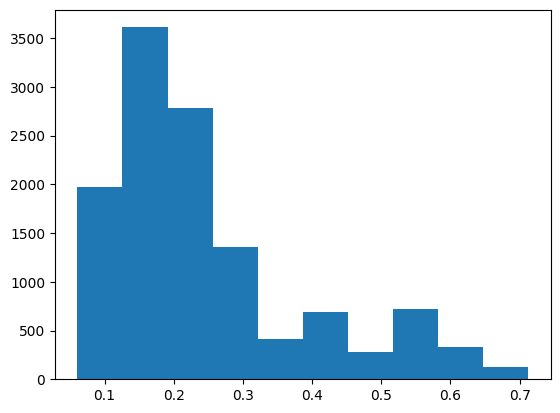

In [255]:
plt.hist(LArr)
plt.show()

(273, 2)


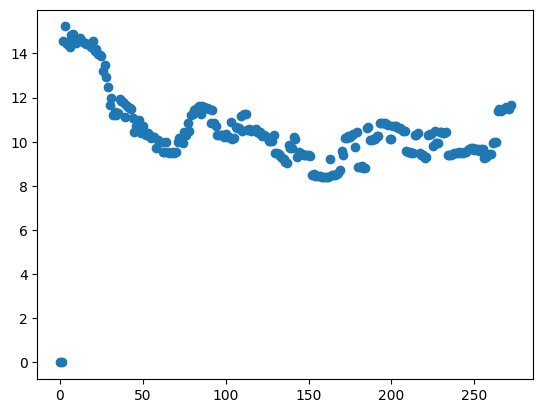

[ 2.         14.57759519]


In [256]:


print(np.shape(pressure))
plt.scatter(pressure[:,0],pressure[:,1])
plt.show()

print(pressure[1,:])

In [ ]:
print(np.max(LArr))